## Import Library

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import copy
import matplotlib.pyplot as plt
import gdown
import zipfile
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch.nn.functional as F

In [2]:
# !pip install gdown

## Download and unzip dataset using gdown package

In [4]:
# URL of the file on Google Drive
file_url = 'https://drive.google.com/uc?export=download&id=1q5tUYDu60nNYFVX1sgMMOWhPX4sd8eZG'
# Path where the file will be downloaded
output_path = 'seendataset.zip'
# Path where the file will be unzipped
unzip_dir = 'seendataset'

# Download the file from Google Drive
gdown.download(file_url, output_path, quiet=False)

# Create the destination directory if it does not exist
os.makedirs(unzip_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# List the files in the destination directory to verify extraction
extracted_files = os.listdir(unzip_dir)
print(extracted_files)

In [5]:
import zipfile

zip_file_path = 'test_dataset.zip'
extract_dir = 'test'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)


## Data Prepration And Tranform Images For More Augmentation During Training

In [6]:
# Define directories
train_dir = '/kaggle/input/newdataset/seendataset(416)/bird dataset/train'
val_dir = '/kaggle/input/newdataset/seendataset(416)/bird dataset/val'

# Define image transformations
data_transforms = {
    'train': transforms.Compose([
#         transforms.Resize((416,416)),
        transforms.RandomRotation(degrees=(0,360)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968,0.48215841,0.44653091], [0.24703223,0.24348513,0.26158784])
    ]),
    'val': transforms.Compose([
#         transforms.Resize((416,416)),
        # transforms.RandomRotation(degrees=(0,360)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968,0.48215841,0.44653091], [0.24703223,0.24348513,0.26158784])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join('/kaggle/input/newdataset/seendataset(416)/bird dataset', x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4, pin_memory=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Define Classes

In [7]:
class_names=['Asian-Green-Bee-Eater',
 'Brown-Headed-Barbet',
 'Cattle-Egret',
 'Common-Kingfisher',
 'Common-Myna',
 'Common-Rosefinch',
 'Common-Tailorbird',
 'Coppersmith-Barbet',
 'Forest-Wagtail',
 'Gray-Wagtail',
 'Hoopoe',
 'House-Crow',
 'Indian-Grey-Hornbill',
 'Indian-Peacock',
 'Indian-Pitta',
 'Indian-Roller',
 'Jungle-Babbler',
 'Northern-Lapwing',
 'Red-Wattled-Lapwing',
 'Ruddy-Shelduck',
 'Rufous-Treepie',
 'Sarus-Crane',
 'White-Breasted-Kingfisher',
 'White-Breasted-Waterhen',
 'White-Wagtail']
class_names

['Asian-Green-Bee-Eater',
 'Brown-Headed-Barbet',
 'Cattle-Egret',
 'Common-Kingfisher',
 'Common-Myna',
 'Common-Rosefinch',
 'Common-Tailorbird',
 'Coppersmith-Barbet',
 'Forest-Wagtail',
 'Gray-Wagtail',
 'Hoopoe',
 'House-Crow',
 'Indian-Grey-Hornbill',
 'Indian-Peacock',
 'Indian-Pitta',
 'Indian-Roller',
 'Jungle-Babbler',
 'Northern-Lapwing',
 'Red-Wattled-Lapwing',
 'Ruddy-Shelduck',
 'Rufous-Treepie',
 'Sarus-Crane',
 'White-Breasted-Kingfisher',
 'White-Breasted-Waterhen',
 'White-Wagtail']

## Set Device As Cuda For Faster Computation

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model Define

In [10]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(batch_size, num_channels)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(batch_size, num_channels, 1, 1)
        return x * y.expand_as(x)

class BirdClassificationModel(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SEBlock(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1, groups=128),  # Depthwise Convolution
            nn.Conv2d(256, 256, 1),  # Pointwise Convolution
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            SEBlock(256),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, padding=1, groups=256),  # Depthwise Convolution
            nn.Conv2d(256, 256, 1),  # Pointwise Convolution
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            SEBlock(256),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1, groups=256),  # Depthwise Convolution
            nn.Conv2d(512, 512, 1),  # Pointwise Convolution
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512),
            nn.MaxPool2d(2),

            nn.Conv2d(512, 512, 3, padding=1, groups=512),  # Depthwise Convolution
            nn.Conv2d(512, 512, 1),  # Pointwise Convolution
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512),
            nn.MaxPool2d(2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, 512),  
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024,output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h


## Set Output Layer With 25 Classes

In [11]:
OUTPUT_DIM = 25

model = BirdClassificationModel(OUTPUT_DIM)

## Visualize Model

In [12]:
#print the model

print(model)

BirdClassificationModel(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): SEBlock(
      (fc1): Linear(in_features=128, out_features=8, bias=False)
      (fc2): Linear(in_features=8, out_features=128, bias=False)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
    (6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): SEBlock(
      (fc1): Linear(in_features=256, out_features=16, bias=False)
      (fc2): Linear(in_features=16, out_features=256, bias=False)
    )
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11):

## Print Total Parameters In Model

In [13]:
#print total trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,579,801 trainable parameters


## Set Model To Train At GPU And Define Loss Function As Well As Optimizer With Learning rate, weight_decay And Scheduler

In [14]:
model= model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


## Start Training With Early Stopping to Monitor Model Underfitting and Underfitting With Patience 5

In [15]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=40, patience=5, scheduler=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Check if 'outputs' is a tuple
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Early Stopping
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if scheduler:
                    scheduler.step(epoch_loss)  # Use validation loss to adjust learning rate

                if epochs_no_improve >= patience:
                    print(f'Early stopping at epoch {epoch} with best validation loss: {best_val_loss:.4f}')
                    model.load_state_dict(best_model_wts)
                    history = {
                        'train_loss': train_loss_history,
                        'train_acc': train_acc_history,
                        'val_loss': val_loss_history,
                        'val_acc': val_acc_history
                    }
                    return model, history

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)

    # Save the training history
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }

    return model, history

# Assuming 'model', 'criterion', 'dataloaders', 'dataset_sizes', and 'device' are already defined
model, history = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=40, patience=5, scheduler=scheduler)


Epoch 0/39
----------
train Loss: 2.1531 Acc: 0.3562
val Loss: 1.5953 Acc: 0.5181

Epoch 1/39
----------
train Loss: 1.2920 Acc: 0.6065
val Loss: 1.1315 Acc: 0.6528

Epoch 2/39
----------
train Loss: 0.9819 Acc: 0.7020
val Loss: 0.7239 Acc: 0.7714

Epoch 3/39
----------
train Loss: 0.8127 Acc: 0.7526
val Loss: 0.7387 Acc: 0.7748

Epoch 4/39
----------
train Loss: 0.7076 Acc: 0.7828
val Loss: 0.5247 Acc: 0.8406

Epoch 5/39
----------
train Loss: 0.6270 Acc: 0.8086
val Loss: 0.6243 Acc: 0.8137

Epoch 6/39
----------
train Loss: 0.5820 Acc: 0.8217
val Loss: 0.5075 Acc: 0.8473

Epoch 7/39
----------
train Loss: 0.5321 Acc: 0.8343
val Loss: 0.4070 Acc: 0.8714

Epoch 8/39
----------
train Loss: 0.4741 Acc: 0.8538
val Loss: 0.4171 Acc: 0.8710

Epoch 9/39
----------
train Loss: 0.4498 Acc: 0.8610
val Loss: 0.3500 Acc: 0.8965

Epoch 10/39
----------
train Loss: 0.4135 Acc: 0.8708
val Loss: 0.3925 Acc: 0.8802

Epoch 11/39
----------
train Loss: 0.3852 Acc: 0.8783
val Loss: 0.3462 Acc: 0.8982

Ep

## Plot Training History

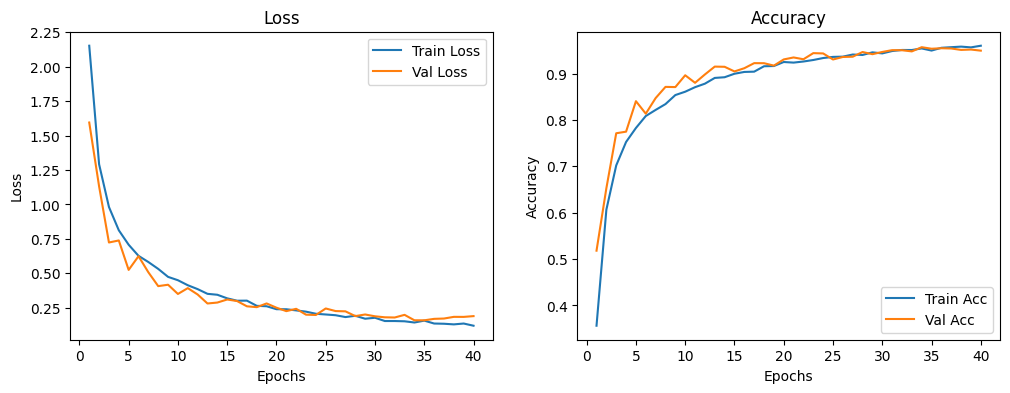

In [16]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)


## Save Model 

In [17]:
torch.save(model.state_dict(), 'bird_classification_model(extra-small).pth')

## Convert Model to Script Type

In [ ]:
scripted_model = torch.jit.script(model)

# Save the scripted model to a file
scripted_model.save("scripted_bird_classification_model.pt")

In [ ]:

# # load model in gpu for faster computution
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load('/kaggle/working/bird_classification_model(extra-small).pth', map_location=device))
# model.to(device)
# model.eval()
# #transform data into model input size 416*416 and normalize
# data_transforms = {
#     'test': transforms.Compose([
#         transforms.RandomRotation(0),  
#         transforms.Resize((416, 416)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
#     ])
# }

# def predict_bird_species(model, img_path):
#     img = Image.open(img_path)
#     transform = data_transforms['test']
#     img = transform(img).unsqueeze(0).to(device)

#     with torch.no_grad():
#         outputs = model(img)
#         if isinstance(outputs, tuple):
#             outputs = outputs[0]
#         _, preds = torch.max(outputs, 1)

#     return preds[0].item()

# def evaluate_model_on_directory(model, directory_path):
#     all_preds = []
#     all_labels = []
    
#     for root, _, files in os.walk(directory_path):
#         class_name = os.path.basename(root)  # Assume the folder name is the class label
#         if class_name not in class_names:  # Skip directories that are not in the class names
#             continue
        
#         label = class_names.index(class_name)
        
#         for filename in files:
#             if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more image formats if needed
#                 img_path = os.path.join(root, filename)
#                 predicted_label = predict_bird_species(model, img_path)
#                 all_preds.append(predicted_label)
#                 all_labels.append(label)

#     return all_labels, all_preds

# #directory path of test images
# directory_path = '/kaggle/input/newdataset/seendataset(416)/bird dataset/val'
# all_labels, all_preds = evaluate_model_on_directory(model, directory_path)

# # Compute confusion matrix
# conf_matrix = confusion_matrix(all_labels, all_preds)

# # Print confusion matrix and classification report
# print("Confusion Matrix:")
# print(conf_matrix)

# #precision, recall, F1-score for each class
# print("\nClassification Report:")
# print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
# import seaborn as sns
# def plot_confusion_matrix(conf_matrix, class_names):
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.show()

# # Call the function to plot the confusion matrix
# plot_confusion_matrix(conf_matrix, class_names)